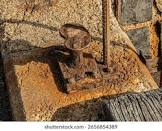

In [1]:
from pathlib import Path
import random
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup path to a data folder
data_path = Path("New Plant Diseases Dataset(Augmented)/")
image_path_list = list(data_path.glob("*/*/*.jpg"))
Image.open(random.choice(image_path_list))

Setting up Directories

In [2]:
train_dir = data_path/ "train"
test_dir = data_path/ "valid"

train_dir,test_dir

(WindowsPath('New Plant Diseases Dataset(Augmented)/train'),
 WindowsPath('New Plant Diseases Dataset(Augmented)/valid'))

Converting image to Tensors

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform = data_transforms ,# a transform for the data
                                  target_transform=None)# a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transforms)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 86698
     Root location: New Plant Diseases Dataset(Augmented)\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 17572
     Root location: New Plant Diseases Dataset(Augmented)\valid
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ))

Keeping them to data loaders

In [5]:
# Turn train and test datasets into DataLoader'
from torch.utils.data import DataLoader
BATCH_SIZE = 64
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,   # use 4 CPU workers (your i7 has multiple cores)
    pin_memory=True  # faster transfer to GPU
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

beta_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader,test_dataloader,beta_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2693c01f010>,
 <torch.utils.data.dataloader.DataLoader at 0x2693c01e0b0>)

In [6]:
class_dict = train_data.class_to_idx
class_dict

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

#### CNN

In [ ]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(out_features=output_shape)  # PyTorch infers in_features automatically
)

    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x)))

Train_Step

In [8]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

Test_Step

In [9]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Mixing Those Ts

In [10]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

c:\Users\gunti\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Looping them bruh...

In [11]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 120

# Recreate an instance of TinyVGG
Super_model = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=64, 
                  output_shape=len(train_data.classes)).to(device)

# Load in the saved state_dict()
Super_model.load_state_dict(torch.load(f="Super_models\\Super_Modelv4.pth"))

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Super_model.parameters(), lr=1e-5, weight_decay=1e-4)


# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=Super_model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/120 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [26]:
loaded_model_2 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=64, 
                  output_shape=len(train_data.classes)).to(device)

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f="Super_models\\Super_Modelv5.pth"))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)
loaded_model_2

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=38, bias=True)
  )
)

### Testing image loader

In [27]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])   # no ToTensor here
])

### Testing Purpose

('Strawberry___Leaf_scorch', 'images (1).jpg')
('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'images (2).jpg')
('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'images (3).jpg')
('Tomato___Septoria_leaf_spot', 'images (4).jpg')
('Apple___Black_rot', 'images (5).jpg')
('Apple___Black_rot', 'images (6).jpg')
('Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Images-of-grape-leaf-disease-8.png')
('Grape___healthy', 'images.jpg')
('Potato___Late_blight', 'late-blight-on-foliage.jpg')
('Strawberry___Leaf_scorch', 'strawberry_Phomopsis_leaf_blight.jpg')
('Pepper,_bell___healthy', 'sweet-pepper-leaf-closeup-isolated-260nw-296306756.webp')


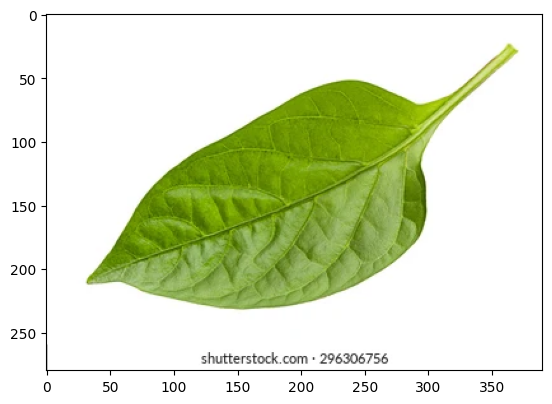

In [39]:
import os
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

path = "test"  # folder name or full path

for root, dirs, files in os.walk(path):
    for file_name in files:
        file_path = os.path.join(root,file_name)
        custom_image_uint8 = torchvision.io.read_image(str(file_path))
        custom_image = custom_image_uint8 / 255.
        custom_image_transformed = custom_image_transform(custom_image)
        loaded_model_2.eval()
        with torch.inference_mode():
            custom_image_pred = loaded_model_2(custom_image_transformed.unsqueeze(dim=0).to(device))
        custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
        lis = []
        # Convert prediction probabilities -> prediction labels
        custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
        lis = custom_image_pred_label
        for key, value in class_dict.items():
            if value == custom_image_pred_label:
                print(f"{key,file_name}")
                plt.imshow(custom_image.permute(1, 2, 0))